# Operation churn

## Imports

In [1]:
import pandas as pd
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import acquire
import prepare
import opchurn

## Acquire

Data was acquired from telco_churn database provided by Codeup  
Database consists of 7,043 rows and 24 columns  
No null values observed at this point  
Total charges dtype is object, will have to convert to float during prep  

## Prepare

Utilized function to drop duplicate columns:  
payment_type_id  
internet_service_type_id  
contract_type_id  

Converted total_charges to float
Discovered Null (blank space) values in total charges.  
Replaced null with 0:
Since new customers have not been charged, the amount is 0  

In [2]:
# acquiring data
df = acquire.get_telco_data()

# cleaning and preparing data
df = prepare.prep_telco(df)

# splitting data into train, validate, test
train, validate, test = prepare.split_function(df, 'churn')

Found CSV


## EDA Process

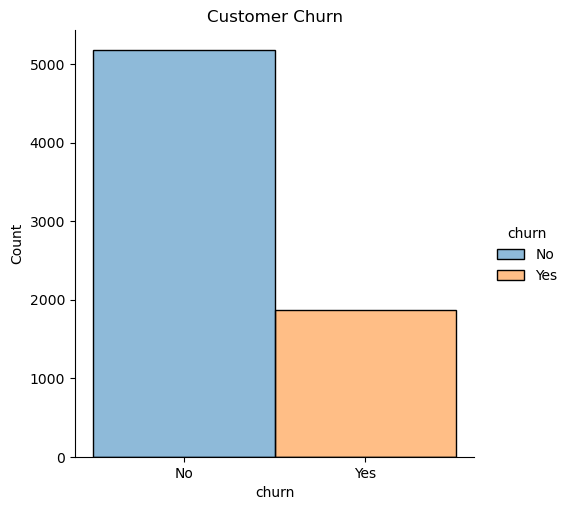

In [3]:
sns.displot(data=df, x='churn', hue='churn')
plt.title('Customer Churn')
plt.show()

**Before** exploring, I **split my data** set into *train, validate, test* and **ONLY** used *train* for exploration.  
I used a function imported from prepare.py file  

### Do monthly charges effect customer churn?

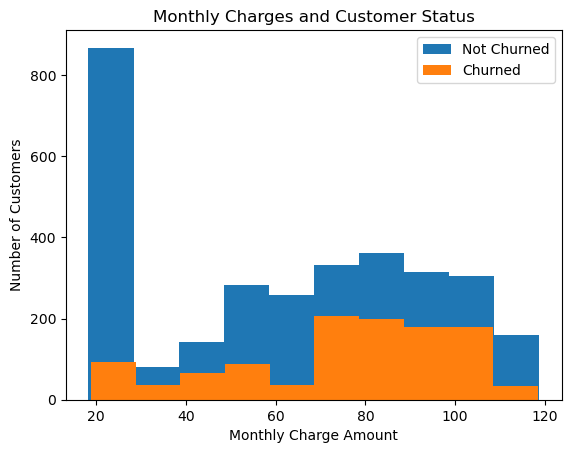

In [4]:
opchurn.get_monthly_charges_plot(train)

$H_0$: Mean of monthly charges of churned customers <= Mean of monthly charges of all customers  
$H_a$: Mean of monthly charges of churned customers > Mean of monthly charges of all customers  
1 sample 1 tail t-test

In [5]:
opchurn.get_monthly_charges_ttest(train)

t = 12.65
p = 1.074e-34
We reject the hypothesis


#### **Takeaway**:  
We can infer that the mean of monthly charges for churned customers are higher than the mean of all customers. Our test results showed that this is statistically significant and I have verified this variable as a **key driver** for customer churn.

### Does internet service type effect customer churn?

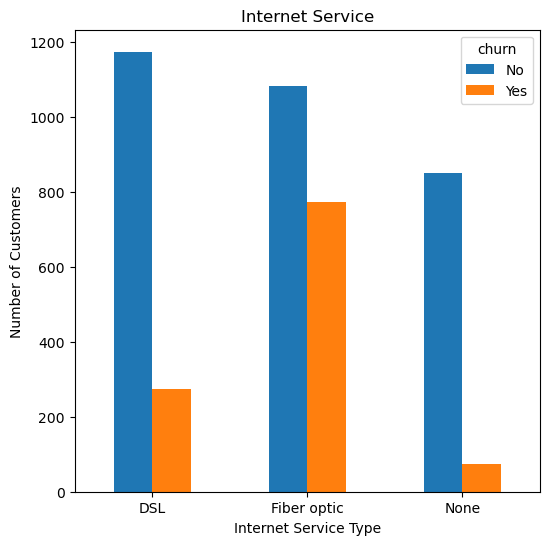

In [6]:
opchurn.get_internet_service_plot(train)

$H_0$: Customer Churn is independent of Internet service type  
$H_a$: Customer Churn is dependent on Internet service  
$Chi^2$ test

In [7]:
opchurn.get_internet_service_chi2(train)

chi^2 = 423.2590
p.    = 0.0000
We reject the null hypothesis


#### **Takeaway:**  
Our test results indicate that internet service type and customer churn are statistically significant. We can see from the graph that there is a high rate of fiber optic service for customers who churn. I have been able to verify that internet service type is a **key driver** for customer churn.

### Does tenure effect customer churn?

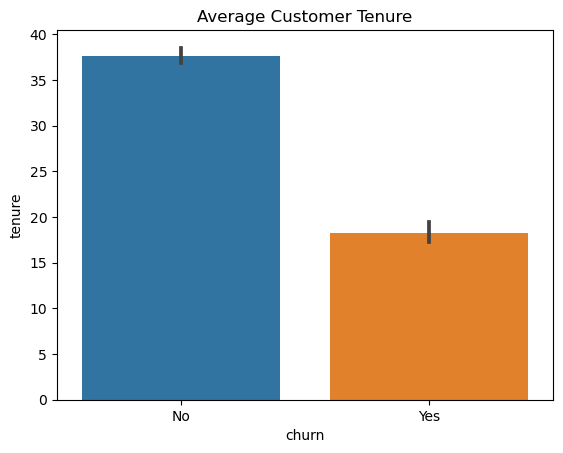

In [8]:
sns.barplot(data=train, x='churn', y='tenure')
plt.title('Average Customer Tenure')
plt.show()

$H_0$: Mean tenure of churned customers == Mean tenure of active customers  
$H_a$: Mean tenure of churned customers != Mean tenure of active customers  
t-test 2-tail

In [9]:
opchurn.get_tenure_ttest(train)

t= -26.58
p= 8.805e-137
We reject the null hypothesis


#### **Takeaway:**  
We can infer that the mean tenure of active customers is higher than the mean tenure of customers who churn.  
Average tenure for active customer is more than 2x's that of churned customers at ~37 months and ~18 months respectively.  
Valuable insight is that the lifetime value of churned customers is half that of active customers making tenure another **key driver** of churn. 

### Does contract type effect customer churn?

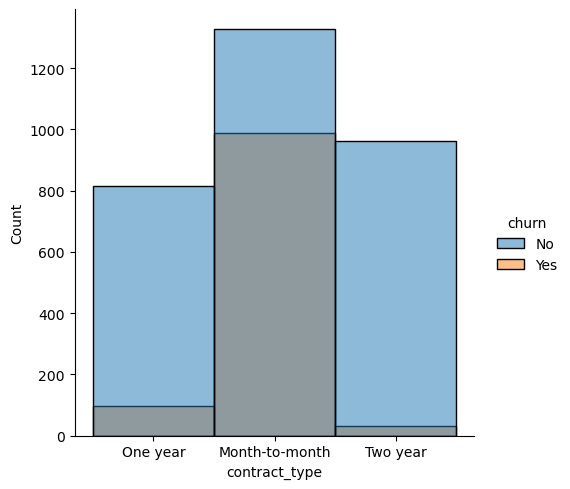

In [10]:
sns.displot(data=train, x='contract_type', hue='churn')
plt.show()

$H_0$: Customer Churn is independent of contract type  
$H_a$: Customer Churn is dependent on contract type  
$Chi^2$ test  

In [11]:
opchurn.get_contract_type_chi2(train)

chi^2 = 703.7871
p.    = 0.0000
We reject the null hypothesis


**Takeaway:**  
Contract type does play a role in customer churn.  
Month-to-month is the bulk of all contracts.  
Month-to-month is 88% of contracts for customers who churn.  

### EDA Summary

**I answered 4 primary questions during the EDA phase of this project:**  

1. ***Does monthly charges effect customer churn?***  
2. ***Does internet service type effect customer churn?***  
3. ***Does tenure effect customer churn?***  
4. ***Does contract type effect customer churn?***  

The outcome for all 4 questions is **Yes**.  
I will be using all 4 features in the modeling phase.  
I was not surprised by the outcomes, I expected all 4 to play a role in customer churn. I wanted to test each to verify.  

### Modeling

#### Introduction  

I will use 3 ML algorithms:  
***Decision Tree*** , ***Random Forests***, & ***Logistic Regression***  
Once multiple iterations are ran for all 3 models, I will pick the best model for each algorithm.  

#### Random Forest

Features used for the first Model:  
- 'tenure'  (statistically significant in stats test)
- 'monthly_charges'  (statistically significant in stats test)
- 'contract_type_One year' , 'contract_type_Two year'  (statistically significant in stats test)
- 'internet_service_type_Fiber optic' , 'internet_service_type_None' (statistically significant in stats test)
- 'tech_support_No internet service' , 'tech_support_Yes' (Did not test this variable but did look significant for senior citizens)

In [54]:
#Calculate baseline accuracy
baseline_accuracy = train[target_variable].value_counts().max() / train[target_variable].value_counts().sum()
print(f'Baseline Accuracy: {baseline_accuracy:.2%}')

Baseline Accuracy: 73.47%


In [81]:
# create variable for columns I want to drop for model
drop_cols = ['senior_citizen', 'total_charges', 'gender_Male', 'partner_Yes', 'dependents_Yes', 'phone_service_Yes'
            , 'multiple_lines_No phone service', 'multiple_lines_Yes', 'online_security_No internet service'
            , 'online_security_Yes', 'online_backup_No internet service', 'online_backup_Yes'
            , 'device_protection_No internet service', 'device_protection_Yes', 'streaming_tv_No internet service'
            , 'streaming_tv_Yes', 'streaming_movies_No internet service', 'streaming_movies_Yes'
            , 'paperless_billing_Yes', 'payment_type_Credit card (automatic)'
            , 'payment_type_Electronic check', 'payment_type_Mailed check']

In [82]:
# create function to initiate X_y train, validate, test
def xy_train_val(train, validate, test, target_variable, drop_cols):
    """
    input train, validate, test, after using split function()
    input target_variable as string
    drop_cols formatted as: ['col1', 'col2', 'etc'] for multiple columns
        This function will drop all 'object' columns. Identify additional 
        columns you want to drop and insert 1 column as a string or multiple
        columns in a list of strings.
    X_train, X_validate, X_test, y_train, y_validate, y_test
    """
    
    baseline_accuracy = train[target_variable].value_counts().max() / train[target_variable].value_counts().sum()
    print(f'Baseline Accuracy: {baseline_accuracy:.2%}')
    
    X_train = train.select_dtypes(exclude=['object']).drop(columns=[target_variable]).drop(columns=drop_cols)
    X_validate = validate.select_dtypes(exclude=['object']).drop(columns=[target_variable]).drop(columns=drop_cols)
    X_test = test.select_dtypes(exclude=['object']).drop(columns=[target_variable]).drop(columns=drop_cols)
    
    y_train = train[target_variable]
    y_validate = validate[target_variable]
    y_test = test[target_variable]
    
    return X_train, X_validate, X_test, y_train, y_validate, y_test

In [83]:
# utilize function and save variables for first model
X_train, X_validate, X_test, y_train, y_validate, y_test = xy_train_val(train, validate, test, 'churn_Yes', drop_cols)

Baseline Accuracy: 73.47%


In [85]:
# verify columns needed stayed and columns dropped appropriately
X_train.head()

,tenure,monthly_charges,tech_support_No internet service,tech_support_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None
5911,26,39.95,0,0,1,0,0,0
2479,47,26.90,1,0,1,0,0,1
5889,1,50.45,0,0,0,0,0,0
6087,69,60.05,0,1,0,1,0,0
785,51,87.55,0,0,1,0,1,0


In [84]:
# verify target variable saved as array
y_train.head()

5911    0
2479    0
5889    1
6087    0
785     0
Name: churn_Yes, dtype: uint8

In [89]:
# first iteration
rf = RandomForestClassifier(random_state=123, min_samples_leaf=1, max_depth=10)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_train)


TN, FP, FN, TP = confusion_matrix(y_train, y_pred).ravel()
all_ = (TP + TN + FP + FN)
accuracy = (TP + TN) / all_
print(f"Accuracy: {accuracy:.2%}\n")

Accuracy: 85.25%



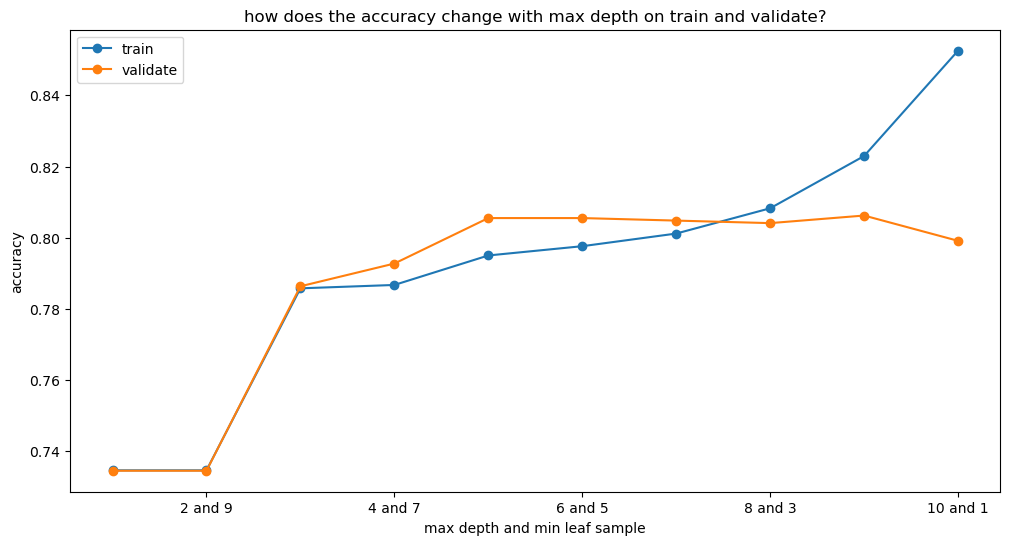

,min_samples_leaf,max_depth,train_acc,val_acc,difference
0,1,10,0.852544,0.799148,0.053396
1,2,9,0.822959,0.806246,0.016713
2,3,8,0.808284,0.804116,0.004168
3,4,7,0.801183,0.804826,-0.003643
4,5,6,0.797633,0.805536,-0.007903
5,6,5,0.795030,0.805536,-0.010506
6,7,4,0.786746,0.792761,-0.006015
7,8,3,0.785799,0.786373,-0.000574
8,9,2,0.734675,0.734564,0.000111
9,10,1,0.734675,0.734564,0.000111


In [87]:
# run loop to find best model accuracy
scores_all = []
for x in range(1,11):
    rf = RandomForestClassifier(random_state=123, min_samples_leaf=x, max_depth=11-x)
    rf.fit(X_train, y_train)
    train_acc = rf.score(X_train, y_train)
    val_acc = rf.score(X_validate, y_validate)
    scores_all.append([x, 11-x, train_acc, val_acc])


scores_df = pd.DataFrame(scores_all, columns=['min_samples_leaf', 'max_depth', 'train_acc', 'val_acc'])
scores_df['difference'] = scores_df.train_acc - scores_df.val_acc



plt.figure(figsize=(12,6))
plt.plot(scores_df.max_depth, scores_df.train_acc, label='train', marker='o')
plt.plot(scores_df.max_depth, scores_df.val_acc, label='validate', marker='o')
plt.xlabel('max depth and min leaf sample')
plt.ylabel('accuracy')

plt.xticks([2,4,6,8,10],
          [('2 and 9'),('4 and 7'),('6 and 5'),('8 and 3'),('10 and 1')]
          )

plt.title('how does the accuracy change with max depth on train and validate?')
plt.legend()
plt.show()
scores_df

In [92]:
for importance, name in sorted(zip(rf.feature_importances_, X_train.columns),reverse=True):
    print (name, importance)

tenure 0.3585411124515877
monthly_charges 0.19965702780668873
internet_service_type_Fiber optic 0.12019996759127581
contract_type_Two year 0.11187900925819831
contract_type_One year 0.08286496873279385
tech_support_Yes 0.04758159054448598
internet_service_type_None 0.042574097883096726
tech_support_No internet service 0.036702225731872866


**Best Model for Random Forest**

In [90]:
# first iteration
rf = RandomForestClassifier(random_state=123, min_samples_leaf=3, max_depth=8)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_train)


TN, FP, FN, TP = confusion_matrix(y_train, y_pred).ravel()
all_ = (TP + TN + FP + FN)
accuracy = (TP + TN) / all_
print(f"Accuracy: {accuracy:.2%}\n")

Accuracy: 80.83%



In [146]:
rf.score(X_validate, y_validate)

0.8041163946061036

#### Decision Tree

In [91]:
#Calculate baseline accuracy
baseline_accuracy = train[target_variable].value_counts().max() / train[target_variable].value_counts().sum()
print(f'Baseline Accuracy: {baseline_accuracy:.2%}')

Baseline Accuracy: 73.47%


In [93]:
# first iteration
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)

TN, FP, FN, TP = confusion_matrix(y_train, y_pred).ravel()
all_ = (TP + TN + FP + FN)
accuracy = (TP + TN) / all_
print(f"Accuracy: {accuracy:.2%}\n")

Accuracy: 98.56%



First iteration appears to overfit with high accuracy

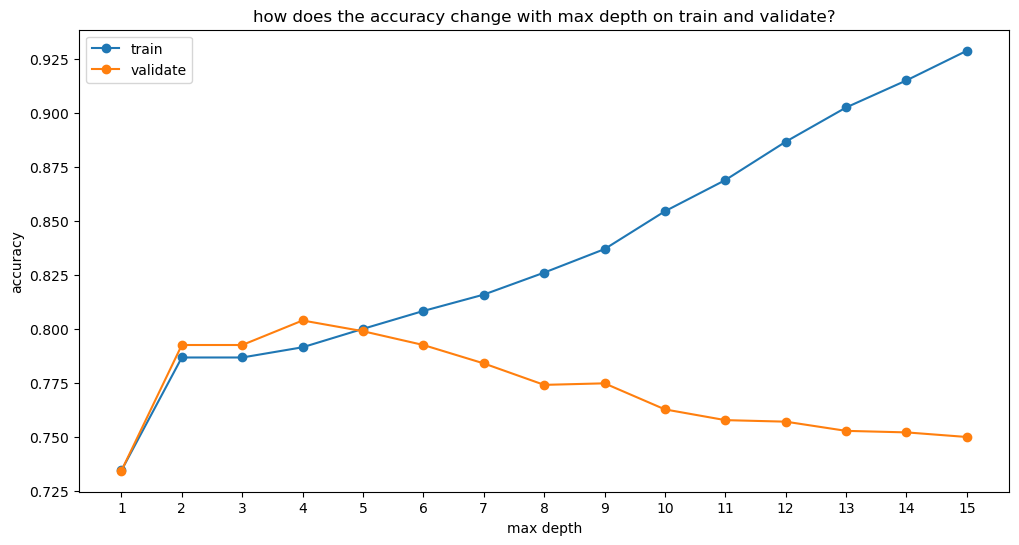

,max_depth,train_acc,val_acc,difference
0,1,0.734675,0.734564,0.000111
1,2,0.786982,0.792761,-0.005779
2,3,0.786982,0.792761,-0.005779
3,4,0.791716,0.804116,-0.012400
4,5,0.800237,0.799148,0.001088
5,6,0.808521,0.792761,0.015760
6,7,0.816095,0.784244,0.031851
7,8,0.826272,0.774308,0.051964
8,9,0.837160,0.775018,0.062142
9,10,0.854675,0.762952,0.091722


In [98]:
# run loop to find best model accuracy
scores_all = []
for x in range(1,16):
    clf = DecisionTreeClassifier(max_depth=x)
    clf.fit(X_train, y_train)
    train_acc = clf.score(X_train, y_train)
    val_acc = clf.score(X_validate, y_validate)
    scores_all.append([x, train_acc, val_acc])


scores_df = pd.DataFrame(scores_all, columns=['max_depth', 'train_acc', 'val_acc'])
scores_df['difference'] = scores_df.train_acc - scores_df.val_acc



plt.figure(figsize=(12,6))
plt.plot(scores_df.max_depth, scores_df.train_acc, label='train', marker='o')
plt.plot(scores_df.max_depth, scores_df.val_acc, label='validate', marker='o')
plt.xlabel('max depth')
plt.ylabel('accuracy')

plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])

plt.title('how does the accuracy change with max depth on train and validate?')
plt.legend()
plt.show()
scores_df

In [100]:
for importance, name in sorted(zip(clf.feature_importances_, X_train.columns),reverse=True):
    print (name, importance)

tenure 0.5200224068566701
internet_service_type_Fiber optic 0.34126665515825594
contract_type_One year 0.03873574180364324
monthly_charges 0.026168627885213496
tech_support_No internet service 0.021402387737185984
internet_service_type_None 0.01856751799159292
contract_type_Two year 0.01856614294696628
tech_support_Yes 0.015270519620472007


**Best Model for Decision Tree**

In [144]:
clf = DecisionTreeClassifier(max_depth=5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)

TN, FP, FN, TP = confusion_matrix(y_train, y_pred).ravel()
all_ = (TP + TN + FP + FN)
accuracy = (TP + TN) / all_
print(f"Accuracy: {accuracy:.2%}\n")

Accuracy: 80.02%



In [145]:
clf.score(X_validate, y_validate)

0.7991483321504613

#### Logistic Regression

In [101]:
#Calculate baseline accuracy
baseline_accuracy = train[target_variable].value_counts().max() / train[target_variable].value_counts().sum()
print(f'Baseline Accuracy: {baseline_accuracy:.2%}')

Baseline Accuracy: 73.47%


**Best Model for Logistic Regression**

In [102]:
logit = LogisticRegression()
logit.fit(X_train, y_train)
y_pred = logit.predict(X_train)

TN, FP, FN, TP = confusion_matrix(y_train, y_pred).ravel()
all_ = (TP + TN + FP + FN)
accuracy = (TP + TN) / all_
print(f"Accuracy: {accuracy:.2%}\n")

Accuracy: 78.51%



/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [143]:
logit.score(X_validate, y_validate)

0.7977288857345636

In [105]:
X_train.head()

,tenure,monthly_charges,tech_support_No internet service,tech_support_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None
5911,26,39.95,0,0,1,0,0,0
2479,47,26.90,1,0,1,0,0,1
5889,1,50.45,0,0,0,0,0,0
6087,69,60.05,0,1,0,1,0,0
785,51,87.55,0,0,1,0,1,0


In [106]:
features = ['tenure', 'monthly_charges', 'contract_type_One year', 'contract_type_Two year'
            , 'internet_service_type_Fiber optic', 'internet_service_type_None']

In [108]:
X_train[features].head()

,tenure,monthly_charges,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None
5911,26,39.95,1,0,0,0
2479,47,26.90,1,0,0,1
5889,1,50.45,0,0,0,0
6087,69,60.05,0,1,0,0
785,51,87.55,1,0,1,0


In [109]:
logit2 = LogisticRegression()
logit2.fit(X_train[features], y_train)
y_pred = logit2.predict(X_train[features])

TN, FP, FN, TP = confusion_matrix(y_train, y_pred).ravel()
all_ = (TP + TN + FP + FN)
accuracy = (TP + TN) / all_
print(f"Accuracy: {accuracy:.2%}\n")

Accuracy: 78.34%



### Model Summary

Decision Tree, Random Forest, and Logistic Regression models all performed above baseline on train and validate.  
Random Forest and Decision Tree both scored ~80% on train and validate with Random Forest having slightly higher scores on both.  
Logistic Regression model selected as the final model and had an accuracy of ~78.5% which was below both Random Forest and Decision Tree but above baseline.

### Conclusions

#### Exploration  
- Identified and verified 4 **key drivers** of churn:
    - Monthly charges
    - Tenure
    - Internet service type (i.e. DSL, Fiber optic, None)
    - Contract type (i.e. Month-to-month, 1 year, 2 year)
<br>
<br>
- Prioritized these key drivers in my modeling stage

#### Modeling

Final model performed above baseline and had a Test accuracry of (insert here)

#### Recommendations

